### Import libraries

In [1]:
import sys
sys.path.append("..")
from model import classic_model, combined_model, experimental_model, losses, grapher
from data import data_generation, batch_creator, gp_kernels, gp_priors, loader
from helpers import helpers, plotter, masks
from keras.callbacks import ModelCheckpoint
from inference import infer
import tensorflow as tf; import keras
import time
import numpy as np

Using TensorFlow backend.


In [2]:
save_dir = '/Users/omernivron/Downloads/GPT'

In [3]:
# pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generation.data_generator_for_gp_mimick_gpt(150000, ordered = False, same_x = True)

In [4]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te = loader.load_data()

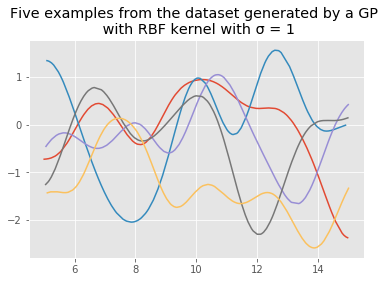

In [5]:
plotter.plot_examples(pad_pos_tr, pad_y_fren_tr)

In [84]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [85]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)
# batch_pos_tr1 = batch_pos_tr[:, :-1]
# batch_pos_tr_current = batch_pos_tr[:, 1:]

In [86]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=30)
# batch_pos_tr1 = batch_pos_tr[:, :-1]
# batch_pos_tr_current = batch_pos_tr[:, 1:]

Already exists
Restored from /Users/omernivron/Downloads/GPT/ckpt/check__run_10_heads_32_encoding_1024/ckpt-49


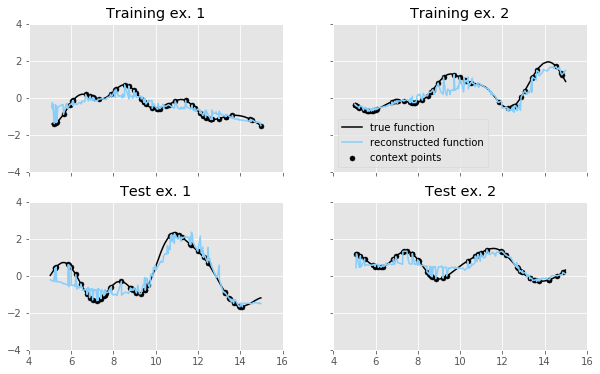

Epoch 0 batch 0 train Loss -0.0114 test Loss -0.0054 with training MSE metric 0.1759 and testing MSE metric 0.1803
learning rate is 1.0000000116860974e-07


In [ ]:
if __name__ == '__main__':
    EPOCHS = 75; batch_s  = 64; run = 10; step = 0; train_steps = 10000; heads = 32; ℯ = 1024
    logdir = save_dir + '/logs/' + '_run_' + str(run) + '_heads_' + str(heads) + '_encoding_' + str(ℯ)
    writer = tf.summary.create_file_writer(logdir)
    lr_fn = tf.optimizers.schedules.PolynomialDecay(4e-3, train_steps, 1e-7, 2)
    optimizer_c = tf.keras.optimizers.Adam(lr_fn)
    decoder = experimental_model.Decoder(ℯ, num_heads = heads); tf.random.set_seed(443)   
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
#     num_batches = 1500
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    main_folder = "/Users/omernivron/Downloads/GPT/ckpt/check_"
    folder = main_folder + '_run_' + str(run) + '_heads_' + str(heads) + '_encoding_' + str(ℯ); helpers.mkdir(folder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    with writer.as_default():
        for epoch in range(EPOCHS):
            m_tr.reset_states(); train_loss.reset_states()
            m_te.reset_states(); test_loss.reset_states()
            start = time.time()

            for batch_n in range(num_batches):

                batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=64)
                pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, batch_pos_tr, batch_tar_tr)
                sst = np.mean(np.sum((batch_tar_tr[:, 51:]) ** 2, 0))
                if batch_n % 300 == 0:
                    pred_te, pred_log_te = test_step(decoder, test_loss, m_te, pad_pos_te[:500, :], pad_y_fren_te[:500, :])
                    plotter.follow_training_plot(batch_pos_tr, batch_tar_tr, pred, pad_pos_te[:500, :], pad_y_fren_te[:500, :], pred_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [81]:
np.mean(np.sum((batch_tar_tr[:, 51:] - np.repeat(np.mean(batch_tar_tr, 1), 149).reshape(64, -1)) ** 2, 1))

120.51542349224675